# Computer lab : Let’s reverse-engineer the data center

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [76]:
#Load data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

In [77]:
# Loading raw data
data = pd.read_csv('Raw_Dataset_May.csv')

def name_to_subcategory_and_details(col_name):
    if np.isreal(col_name):
        col_name = names[col_name]
    indices = np.nonzero((data['NAME'] == col_name).values)[0]
    if len(indices) > 0:
        subcategory = data['SUBCATEGORY'].iloc[[indices[0]]].values[0]
        details = data['DETAILS'].iloc[[indices[0]]].values[0]
        return subcategory, details
    else:
        print('unknown name')

### 3 Least squares

##### **Question 3.1**

We have : 
\begin{align*}
Aw = \tilde{x}(t)^{\intercal} w_1 + w_0 - y(t) \cdot \tilde{x}(t)^{\intercal} w_2
\end{align*}
and $Aw = b $ and $b=y(t)$  
hence
\begin{align*}
y(t) + y(t) \cdot \tilde{x}(t)^{\intercal} w_2 = \tilde{x}(t)^{\intercal} w_1 + w_0 \\
y(t)( 1+\tilde{x}(t)^{\intercal} w_2 ) = \tilde{x}(t)^{\intercal} w_1 + w_0 \\
\end{align*}
We have also :
$\tilde{x}(t)^{\intercal} w_2 = w_2^{\intercal}\tilde{x}(t)$ because the scalar product is symetric.
Therefor we get the following solution :
\begin{align*}
y(t)= \frac {w_1^{\intercal}\tilde{x}(t) + w_0 } { w_2^{\intercal}\tilde{x}(t) +1}\\
\end{align*}

##### **Question 3.2**

In [78]:
# Constructing matrices for min_w ||A w - b||_2**2

matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean
matrix_std = np.std(M, axis=0)
M = M / matrix_std

A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3] #KPI 4

In [79]:
def score(A,b,w):
    residuals= A@w-b
    return 1/2 * np.linalg.norm(residuals, ord=2)**2

In [80]:
sol = np.linalg.lstsq(A, b, rcond=None)[0]
sol
score(A,b,sol)

3.3773566030175728e-25

##### **Question 3.3**

In [81]:
# Constructing matrices for the test set
M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

print(score(A_test,b_test,sol))
print(np.linalg.norm(b))

140952.17552310223
122.17911408068046


Le test n'est pas du tout efficace.


##### **Question 3.4**

On utilise la régression de ridge

In [82]:
lamb = 100

#regression de ridge avec lambda = 100

sol_ridge = np.linalg.lstsq(A.T@A+lamb*np.eye(A.shape[1]), A.T@b, rcond=None)[0]
sol_ridge

array([-0.01238313,  0.05780406, -0.00127775, ...,  0.01590558,
       -0.03567897,  0.0131232 ])

In [83]:
print(score(A_test,b_test,sol_ridge))

54340.396471043765


Le résultat est bien meilleur que sans régularisation

##### **Question 3.5**

\begin{align*}
f_1(w + \delta{w}) &= \frac{1}{2} ||(A(w+\delta{w})-b)||^2 + \frac {\lambda}{2} ||w + \delta{w} ||^2\\
&= \frac {1} {2}  (||(A(w)-b)||^2 + ||A\delta{w}||^2 + 2 \langle Aw - b, A\delta{w} \rangle ) +  \frac {\lambda}{2} (||w||^2+||\delta{w}||^2+ 2 \langle w, \delta{w} \rangle ) \\
&= f_1(w) +  \langle Aw - b, A\delta{w} \rangle + \frac {1} {2}||A\delta{w}||^2 + \frac {\lambda}{2}(||\delta{w}||^2+ 2 \langle w, \delta{w} \rangle ) \\
&= f_1(w) + \langle Aw - b, A\delta{w} \rangle + \lambda \langle w, \delta{w} \rangle + o(\delta{w} ) \\
&= f_1(w) + \langle A^T(Aw - b) + \lambda w, \delta{w} \rangle + o(\delta{w} ) \\
\end{align*}

Ainsi, le gradient de  f est $ \nabla{f_1}(w) = (A^TA + \lambda Id )w - A^Tb\\$
et la hessienne est : $\nabla^2{f_1}(w) = A^TA + \lambda Id \\$
$A^TA$ est symétrique positive donc $\nabla^2{f_1}(w)$ est la fonction est convexe.

##### **Question 3.6**

In [84]:
# Function f1 and its gradient
def f1(x):
    return 1/2* np.linalg.norm(A@x-b)**2 + lamb/2 * np.linalg.norm(x)**2

def gradient_f1(x):
    return (A.T.dot(A.dot( x )- b) + lamb * x )

def gradient_f1_2(x,a1,a2):
    return a1.dot(x) + a2


# Gradient Descent
def gradient_descent(gradient_step_size, max_iter, x0= np.zeros(A.shape[1])):
    for i in range(max_iter):
        g= gradient_f1(x0)
        w= x0 - gradient_step_size * g
    return w


def gradient_descent_2(grad_f, x0, alpha, epsilon, max_iter, lamb=200, threshold=1):
    x = x0
    const = A.T.dot(b)
    const2 = A.T.dot(A) - lamb*np.eye(A.shape[1])
    g = gradient_f1_2(x,const2,const)

    test = True
    thresh_iter = max_iter
    while np.linalg.norm(g) > epsilon and max_iter > 0:
        if np.linalg.norm(g) < threshold and test:
            thresh_iter -= max_iter 
            test = False
            print(np.linalg.norm(g))
        x = x - alpha * g
        max_iter -= 1
        g = grad_f(x, const2, const)
    return x,max_iter, thresh_iter

pas = 1 / (np.linalg.norm(A.T @ A) + lamb)
# sol, iter, thresh_iter = gradient_descent(gradient_f1, np.zeros(A.shape[1]), pas, 1e-3 , 100000)
# sol,iter, thresh_iter 

sol = gradient_descent(pas, max_iter = 10000)
print(score(A_test,b_test,sol))

4173.004962499687


## 4 **Regularization for a sparse model**

##### **Question 4.1**

$F_2 = \frac{1}{2} \|Aw - b\|^2 + \lambda \|w\|_1 = f_2 + g_2$ with $f_2 =  \frac{1}{2} \|Aw - b\|^2$ and $g_2 =  \lambda \|w\|_1$.

$f_2$ is differentiable and $\nabla f_2 (w) = A^\top A w  - A^\top b$

The proximal gradient operator of $g_2$ is $prox_{\gamma g_2} (w) = \text{sign}(w) \max(|w| - \gamma \lambda, 0)$

In [107]:
lambda0 = 200

def prox_g2(w, lamb, gamma):
    w2 = np.sign(w) * np.maximum(np.abs(w) - gamma * lamb, 0)
    return w2

def f2(x):
    return 1/2 * np.linalg.norm(A@x-b)**2

def grad_f2(w):
    return A.T @ (A @ w - b)

def proximal_gradient_descent(grad_f, prox_g, x0, alpha, epsilon, max_iter, lamb=200, threshold=1):
    x = x0
    g = grad_f(x)
    test = True
    thresh_iter = max_iter
    while np.linalg.norm(alpha * g) > epsilon and max_iter > 0:
        if np.linalg.norm(g) < threshold and test:
            thresh_iter -= max_iter
            test = False
        x = prox_g2(x - alpha * g, lamb, alpha)
        max_iter -= 1
        g = grad_f(x)
    return x,max_iter, thresh_iter

sol, iter, thresh_iter = proximal_gradient_descent(grad_f2, prox_g2, np.zeros(A.shape[1]), pas, 1 , 10000)
score(A_test,b_test,sol)

14409.075467007513

In [109]:
def line_search(x_k, a=0.5,  lamb=200, beta = 0.5):

    gammaK = beta * a
    x_ = prox_g2(x_k - gammaK * grad_f2(x_k),lamb, gammaK) 
    while f2(x_) > f2(x_k) + np.dot( x_ - x_k, grad_f2(x_k)) + 1/(2* gammaK)*np.linalg.norm(x_k - x_)**2:
        x_k = x_
        gammaK *= a
        x_= prox_g2(x_k - gammaK * grad_f2(x_k),lamb, gammaK)        
    return x_,gammaK

def proximal_gradient_descent_line_search(beta, max_iter, x0 = np.zeros(A.shape[1])):
    x = x0
    g = grad_f2(x)
    while max_iter > 0:
        if max_iter % 100 == 0:
            print(max_iter)
        x, alpha = line_search(x, beta)
        max_iter -= 1
        g = grad_f2(x)
    return x,max_iter

sol, iter = proximal_gradient_descent_line_search( 0.5,10000)
score(A_test,b_test,sol)

10000


C:\Users\eliot\AppData\Local\Temp\ipykernel_23912\1342052211.py:5: RuntimeWarning: overflow encountered in double_scalars
  while f2(x_) > f2(x_k) + np.dot( x_ - x_k, grad_f2(x_k)) + 1/(2* gammaK)*np.linalg.norm(x_k - x_)**2:
C:\Users\eliot\AppData\Local\Temp\ipykernel_23912\1342052211.py:5: RuntimeWarning: invalid value encountered in double_scalars
  while f2(x_) > f2(x_k) + np.dot( x_ - x_k, grad_f2(x_k)) + 1/(2* gammaK)*np.linalg.norm(x_k - x_)**2:
C:\Users\eliot\AppData\Local\Temp\ipykernel_23912\3889215407.py:10: RuntimeWarning: overflow encountered in matmul
  return 1/2 * np.linalg.norm(A@x-b)**2
C:\Users\eliot\AppData\Local\Temp\ipykernel_23912\3889215407.py:10: RuntimeWarning: invalid value encountered in matmul
  return 1/2 * np.linalg.norm(A@x-b)**2
C:\Users\eliot\AppData\Local\Temp\ipykernel_23912\3889215407.py:13: RuntimeWarning: overflow encountered in matmul
  return A.T @ (A @ w - b)
C:\Users\eliot\AppData\Local\Temp\ipykernel_23912\3889215407.py:13: RuntimeWarning: in

9900
9800
9700
9600
9500
9400
9300
9200
9100
9000
8900
8800
8700
8600
8500
8400
8300
8200
8100
8000
7900
7800
7700
7600
7500
7400
7300
7200
7100
7000
6900
6800
6700
6600
6500
6400
6300
6200
6100
6000
5900
5800
5700
5600
5500
5400
5300
5200
5100
5000
4900
4800
4700
4600
4500
4400
4300
4200
4100
4000
3900
3800
3700
3600
3500
3400
3300
3200
3100
3000
2900
2800
2700
2600
2500
2400
2300
2200
2100
2000
1900
1800
1700
1600
1500
1400
1300
1200
1100
1000
900
800
700
600
500
400
300
200
100


nan

## 5. Choice of the regularization parameter

14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467007513
14409.075467

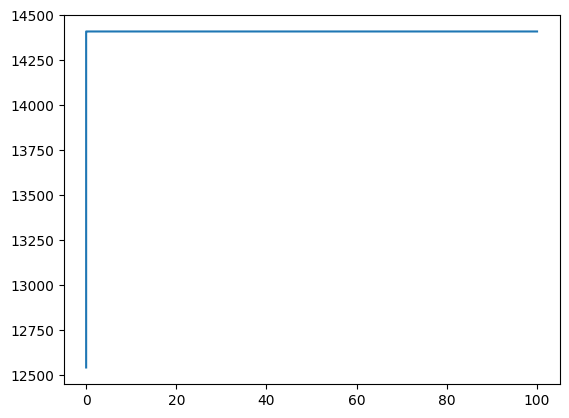

In [ ]:
# For conventional gradient descent with lasso regularization

rho0 = 100
a = 0.9
K = 100

parameters = [rho0 * a ** k for k in range(K)]
scores = []

for rho in parameters:
    # sol, _, _ = gradient_descent_2(gradient_f1_2, np.zeros(A.shape[1]), pas, 1, 1000, lamb=rho)
    sol, _, _ = proximal_gradient_descent(grad_f2, prox_g2, np.zeros(A.shape[1]), pas, 1 , 1000, rho=rho)
    scores.append(score(A_test, b_test, sol))
    print(scores[-1])

scores = np.array(scores)
print("Best regularization parameter:", parameters[scores.argmin()])
print("Best 0-1 loss" , scores.min())

plt.plot(parameters, scores)